# Microbot Live Annotator

Jupyter notebook designed to select an area of your screen and apply edge
detection libraries to locate microbots in cell cultures. Please refer to
`README.md` for additional help in running this notebook.

You only need to run Step 1 and 2 cells once to import necessary modules and
initialize parameter adjustment for trackpy.locate() (used to apply edge
detection for the microbots).

Steps 3 and 4 can be re-run as many times as necessary to crop your screen and
start microbot detection, respectively.

In [1]:
# (STEP 1) RUN TO IMPORT NECESSARY MODULES
# enable ipympl backend for interactive matplotlib graphs
%matplotlib widget

from utils.crop_utils import *
from utils.csv_utils import *
import datetime

### Trackpy Parameters

In [2]:
# (STEP 2a) RUN TO DECLARE DEFAULT TRACKPY LOCATE PARAMETERS

params = {
    "diameter": 13,
    "minmass" : 1500,
    "maxsize" : None,
    "threshold" : 10,
    "noise_size" : 1,
    "topn" : None,
    "separation" : 14,
    "smoothing_size" : 13,
    "percentile": 0
}

In [3]:
# (STEP 2b) RUN TO INITIALIZE TRACKPY PARAMTER ADJUSTMENT SLIDERS
# Create accessible sliders for adjusting trackpy values

diameter_wid = widgets.IntSlider(value=params["diameter"], min=1, max=100, step=2, description="Diameter")
minmass_wid = widgets.IntSlider(value=params["minmass"], min=0, max=3000, step=1, description="Minmass")
maxsize_wid = widgets.IntSlider(value=-1 if params["maxsize"] is None else params["maxsize"], min=-1, max=3000, step=1, description="Maxsize")
threshold_wid = widgets.IntSlider(value=params["threshold"], min=1, max=100, step=1, description="Threshold")
noise_size_wid = widgets.FloatSlider(value=1, min=0, max=10, step=0.1, description="Noise Size")
topn_wid = widgets.IntSlider(value=-1 if params["topn"] is None else params["topn"], min=-1, max=50, step=1, description="Top N")
separation_wid = widgets.IntSlider(value=14, min=0, max=1000, step=1, description="Separation")
smoothing_size_wid = widgets.IntSlider(value=params["smoothing_size"], min=1, max=1000, step=2, description="Smoothing Size")
percentile_wid = widgets.IntSlider(value=params["percentile"], min=0, max=100, step=1, description="Percentile")

# display widgets
display(
    diameter_wid,
    minmass_wid,
    maxsize_wid,
    threshold_wid,
    noise_size_wid,
    topn_wid,
    separation_wid,
    smoothing_size_wid,
    percentile_wid
)

IntSlider(value=13, description='Diameter', min=1, step=2)

IntSlider(value=1500, description='Minmass', max=3000)

IntSlider(value=-1, description='Maxsize', max=3000, min=-1)

IntSlider(value=10, description='Threshold', min=1)

FloatSlider(value=1.0, description='Noise Size', max=10.0)

IntSlider(value=-1, description='Top N', max=50, min=-1)

IntSlider(value=14, description='Separation', max=1000)

IntSlider(value=13, description='Smoothing Size', max=1000, min=1, step=2)

IntSlider(value=0, description='Percentile')

### Screen Cropper

C:\Users\kerbu\AppData\Local\Temp\ipykernel_11256\47050125.py:14: MatplotlibDeprecationWarning: 
The 'drawtype' parameter of __init__() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'drawtype', they should be passed as keyword, not positionally.
  rs = RectangleSelector(


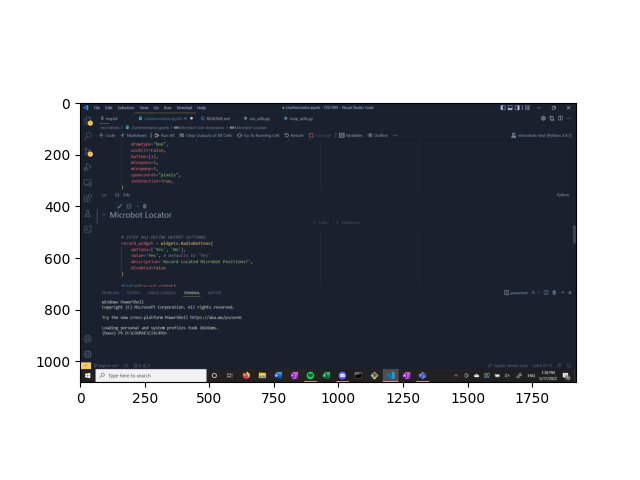

In [4]:
# (STEP 3) RUN TO SELECT A PORTION OF YOUR SCREEN FOR CROPPING
# take initial screenshot of screen
screenshot = pyautogui.screenshot()

# create ScreenshotParams class to save crop selection
coords = ScreenshotCoords()

val1, val2 = None, None

fig, ax = plt.subplots()
ax.imshow(screenshot)

# RectangleSelector plt widget for creating rectangles on a plot
rs = RectangleSelector(
    ax,
    lambda eclick, erelease: update_crop_selection(eclick, erelease, coords),
    drawtype="box",
    useblit=False,
    button=[1],
    minspanx=5,
    minspany=5,
    spancoords="pixels",
    interactive=True,
)

### Microbot Locator

In [10]:
# (STEP 4a) DEFINE OUTPUT SETTINGS
record_widget = widgets.RadioButtons(
    options=['Yes', 'No'],
    value='Yes', # Defaults to "Yes"
    description='Record Located Microbot Positions?',
    disabled=False,
    style={'description_width': 'initial'}
)

display(record_widget)

RadioButtons(description='Record Located Microbot Positions?', options=('Yes', 'No'), style=DescriptionStyle(d…

In [8]:
# (STEP 4b) RUN TO START MICROBOT DETECTION
# Close previous cropper plot to not interfere with cv2.imshow
plt.close('all')

# Get each parameter variable and set it to the widget value, converting
# negative vals to be a None parameter
for param in params.keys():
    val = globals()[param + '_wid'].value
    if val < 0:
        val = None
    params[param] = val

dfs = [] if record_widget.value == "Yes" else None

# continuously take screenshots and annotate them with trackpy, displaying w/ cv2
track_screenshots(coords, params, dfs)

# close all windows
clear_windows()

### Export Located Positions to CSV

In [9]:
# (STEP 6) RUN TO SAVE TRACKPY POSITION TO CSV
csv_name = '{date:%Y-%m-%d_%H:%M:%S}.csv'.format( date=datetime.datetime.now() )
csv_name = csv_name.replace(':', "-")
save_locate_csv(dfs=dfs, csv_name="./output/" + csv_name, search_range=10, memory=10)

File ./output/2022-05-17_13-38-49.csv successfully saved to ./output/./output/2022-05-17_13-38-49.csv
